# Whale and Dolphin Classification Project

Authors:
- Victor Möslein
- Maren Rieker
- Reed Garvin
- Dinah Rabe

This Notebook is one of three core notebooks of the Whale and Dolphin Classification Project for the "Machine Learning" class at the Hertie School. It focuses on the application of classic machine learning models to the task at hand. There is one other notebook concerned with data preprocessing and another that focuses on the application of a deep learning model.

The code of this notebook partly follows the chapter on Classification from the book "Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow" by Aurélien Géron.

In [ ]:
## Setup: System settings and packages

In [1]:
# Python ≥3.5 is required

import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "1.0"

import random
import numpy as np
from numpy import load
import pandas as pd
from numpy import savez_compressed
import os
import timeit
import seaborn as sns
import pickle
import PIL


# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# to make this notebook's output stable
np.random.seed(42)

In [2]:
full_data_switch_on = True # if the full data set should be used, this switch need to be set to true

## Define paths to data and for output

In [3]:
# path to clean data folder
ROOT_PATH_DATA = "input/04_cleaned/"

# where to save figures
ROOT_PATH_FIG = "output/ml_models/01_figures"
os.makedirs(ROOT_PATH_FIG, exist_ok=True)

# where to save output

ROOT_OUTPUT = "output/ml_models/"
OUTPUT_PATH_TRAIN_EVAL = os.path.join(ROOT_OUTPUT + "02_training_set_evaluation")
OUTPUT_PATH_TEST_EVAL = os.path.join(ROOT_OUTPUT + "03_test_set_evaluation")
OUTPUT_PATH_HYPPAR_TUN = os.path.join(ROOT_OUTPUT + "04_hyperparamter_tuning")
OUTPUT_PATH_RUN_TIME = os.path.join(ROOT_OUTPUT + "05_runtime_stats")

# function to save figures

def save_fig(fig_id, save_path=ROOT_PATH_FIG, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(save_path, fig_id + "." + fig_extension)
    print(">... Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Loading and splitting training data

In [4]:
labels_df = pd.read_csv(ROOT_PATH_DATA + "train/clean_train.csv", sep = ';')

In [5]:
labels_df.head() # Checking for correct dimensions after every step. The data set contains 51033 images.

,Unnamed: 0,image,species,individual_id
0,0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,4,00087baf5cef7a.jpg,humpback_whale,8e5253662392


In [10]:
labels_df.shape 

(51033, 4)

In [5]:
labels_full = labels_df["species"]

In [12]:
labels_full.head()

0    melon_headed_whale
1        humpback_whale
2    false_killer_whale
3    bottlenose_dolphin
4        humpback_whale
Name: species, dtype: object

In [13]:
labels_full.shape

(51033,)

In [6]:
pic_ids_full = labels_df["image"]

In [15]:
pic_ids_full.head()

0    00021adfb725ed.jpg
1    000562241d384d.jpg
2    0007c33415ce37.jpg
3    0007d9bca26a99.jpg
4    00087baf5cef7a.jpg
Name: image, dtype: object

In [16]:
pic_ids_full.shape

(51033,)

In [7]:
# load npz files ## has to be adjusted to the actual one
img_data = np.load("input/04_cleaned/train/img_data_full_48.npz")
img_data_full = img_data["arr_0"]

In [8]:
img_data_full.shape

(51033, 6912)

In [9]:
# Split into training and test set - 10.000 test set / 40.000 full training set
# stratify = labels splits it proportionally to classes in the dataset

from sklearn.model_selection import train_test_split
img_data_train_full, img_data_test_no_PCA, labels_train_full, labels_test_no_PCA, pic_ids_train_full, pic_ids_test_no_PCA = train_test_split(img_data_full , labels_full, pic_ids_full, stratify=labels_full, test_size=0.2, random_state=42)


In [10]:
# Split into training and validation set - 30.000 training set / 10.000 validation set
img_data_train_no_PCA, img_data_val_no_PCA, labels_train_no_PCA, labels_val_no_PCA, pic_ids_train_no_PCA, pic_ids_val_no_PCA = train_test_split(img_data_train_full , labels_train_full, pic_ids_train_full, train_size=30000, random_state=42)

## Speed improvements through dimensionality reduction


### Performing Principal Component Analysis on the training data

In [12]:
from sklearn.decomposition import PCA

In [16]:
img_data_full.shape

(51033, 6912)

In [17]:
# defining to keep 99% of the variance of the data
pca = PCA(.95)
img_data_full_red = pca.fit_transform(img_data_full)

In [44]:
# checking how many features are left
img_data_full_red.shape

(51033, 502)

### 1466 features are left when keeping 99% of variance (still too many)
### 502 features are left when keeping 95% of variance

In [42]:
# save dataset after PCA

def store_dict_red(image_df, target_pixel):
    if full_data_switch_on == True:
        savez_compressed("input/04_cleaned/train/img_data_full_red_"+str(target_pixel)+".npz",image_df)
        print("file successfully stored in: input/04_cleaned/train/img_data_full_red_"+str(target_pixel)+".npz")
    elif full_data_switch_on == False:
        savez_compressed("input/04_cleaned/train/img_data_sample_red_"+str(target_pixel)+".npz",image_df)
        print("file successfully stored in: input/04_cleaned/train/img_data_sample_red_"+str(target_pixel)+".npz")
    else:
        raise ValueError("Full data switch is not correctly defined")

### Store reduced image file

In [43]:
store_dict_red(img_data_full_red, target_pixel=48)

file successfully stored in: input/04_cleaned/train/img_data_full_red_48.npz


### Load reduced image file

In [ ]:
# load npz files
img_data_red = np.load("input/04_cleaned/train/img_data_full_red_48.npz")
img_data_full_red = img_data_red["arr_0"]

In [19]:
# Split into training and test set - 10.000 test set / 40.000 full training set
# stratify = labels splits it proportionally to classes in the dataset

from sklearn.model_selection import train_test_split
img_data_train_full, img_data_test, labels_train_full, labels_test, pic_ids_train_full, pic_ids_test = train_test_split(img_data_full_red , labels_full, pic_ids_full, stratify=labels_full, test_size=0.2, random_state=42)


In [20]:
# Split into training and validation set - 30.000 training set / 10.000 validation set
img_data_train, img_data_val, labels_train, labels_val, pic_ids_train, pic_ids_val = train_test_split(img_data_train_full , labels_train_full, pic_ids_train_full, train_size=30000, random_state=42)


In [ ]:
# Checking for correct dimensions.

In [45]:
img_data_train_full.shape

(40826, 502)

In [46]:
img_data_test.shape

(10207, 502)

In [47]:
img_data_train.shape

(30000, 502)

In [48]:
img_data_val.shape

(10826, 502)

In [65]:
# The distribution between training and validation set is similar.
labels_val.value_counts()

bottlenose_dolphin           2270
beluga                       1562
humpback_whale               1522
blue_whale                   1049
false_killer_whale            710
dusky_dolphin                 648
killer_whale                  509
minke_whale                   378
melon_headed_whale            364
spinner_dolphin               347
fin_whale                     307
gray_whale                    238
southern_right_whale          190
short_finned_pilot_whale      165
spotted_dolphin                92
sei_whale                      85
cuviers_beaked_whale           76
common_dolphin                 75
long_finned_pilot_whale        54
white_sided_dolphin            54
pantropic_spotted_dolphin      39
brydes_whale                   30
commersons_dolphin             23
pygmy_killer_whale             20
rough_toothed_dolphin          18
frasiers_dolphin                1
Name: species, dtype: int64

In [66]:
labels_train_full.value_counts()

bottlenose_dolphin           8625
beluga                       5954
humpback_whale               5914
blue_whale                   3864
false_killer_whale           2661
dusky_dolphin                2511
killer_whale                 1964
spinner_dolphin              1360
melon_headed_whale           1351
minke_whale                  1286
fin_whale                    1059
gray_whale                    898
southern_right_whale          693
short_finned_pilot_whale      596
spotted_dolphin               392
sei_whale                     342
common_dolphin                278
cuviers_beaked_whale          273
long_finned_pilot_whale       191
white_sided_dolphin           183
brydes_whale                  123
pantropic_spotted_dolphin     116
commersons_dolphin             72
pygmy_killer_whale             61
rough_toothed_dolphin          48
frasiers_dolphin               11
Name: species, dtype: int64

In [ ]:
# So now we have: 30000 images in the training set, 10826 images in the validation set, 10207 images in the test set

## Implementing baseline model

In [21]:
def train_clasf(classifier_x, img_data_train, labels_train):        
    # set name of classifier
    classifier_name = classifier_x.__class__.__name__
    
    # train model
    print(">... Starting training of", classifier_name)
    start_time = timeit.default_timer()
    classifier_x.fit(img_data_train, labels_train)
    time_elapsed = timeit.default_timer() - start_time
    
    print(">... Classifier {} sucessfully trained in {} seconds.".format(classifier_name, round(time_elapsed,3)))
        

In [23]:
# Running this on the Hertie Server takes around 2 hours with max_iter = 500 and 24 minutes with max_iter = 100 on full image data
# After PCA, it runs in 96 seconds locally with max_iter = 500

# We set solver = 'sag' because stochastic average gradient descent works better on large data sets

from sklearn.linear_model import LogisticRegression

classifier_LR = LogisticRegression(random_state=42, max_iter = 500, solver = 'sag')
train_clasf(classifier_LR, img_data_train, labels_train)

>... Starting training of LogisticRegression
>... Classifier LogisticRegression sucessfully trained in 96.605 seconds.


## Evaluating baseline model ("compute metrics on train AND dev")

In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [25]:
# store predictions of classifier
pred_train = classifier_LR.predict(img_data_train)
pred_val = classifier_LR.predict(img_data_val)

# evaluate classifier and store metrics 
evaluation_scores = {"Precision Score Train": precision_score(labels_train, pred_train, average = "macro").round(3),
                     "Precision Score Validation": precision_score(labels_val, pred_val, average = "macro").round(3),
                     "Recall Score Train": recall_score(labels_train, pred_train, average = "macro").round(3),
                     "Recall Score Validation": recall_score(labels_val, pred_val, average = "macro").round(3),
                     "F1 Score Train": f1_score(labels_train, pred_train, average="macro").round(3),
                     "F1 Score Validation": f1_score(labels_val, pred_val, average="macro").round(3)}


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# save evaluation scores 
def store_eval_score(image_df, classifier_name):
    savez_compressed(OUTPUT_PATH_TRAIN_EVAL + "/evaluation_scores_"+str(classifier_name)+".npz",image_df)
    print("file successfully stored in: output/ml_models/02_training_set_evaluation")


In [27]:
store_eval_score(evaluation_scores, "LogisticRegression")

file successfully stored in: output/ml_models/02_training_set_evaluation


In [ ]:
## Multiclass Confusion Matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

conf_matrix = multilabel_confusion_matrix(labels_val,pred_val,labels=labels_val)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp_conf_matrix = ConfusionMatrixDisplay.from_predictions(labels_val, pred_val)

disp_conf_matrix.show()

In [ ]:
plt.show()

In [55]:
# def function for saving the filtered error table

def store_conf_matrix(disp_conf_matrix, classifier_name):
    disp_conf_matrix.savefig(OUTPUT_PATH_TRAIN_EVAL + "/conf_matrix_"+str(classifier_name)+".jpg")
    print("file successfully stored in: output/ml_models/02_training_set_evaluation")

In [ ]:
# saving the confusion matrix
store_conf_matrix(disp_conf_matrix, "LogisticRegression")

In [28]:
# Inspecting the errors 
output_dict = {}
output_array = np.c_[pic_ids_val, labels_val, pred_val] ## adjust name of pic_ids and labels depending on train or val
    
# Create error array with specific error
err_type_arr = np.array([])
for i in range(len(output_array)):
    if output_array[i,1] != output_array[i,2]:
        err_type_arr = np.append(err_type_arr, "error")
    else:
        err_type_arr = np.append(err_type_arr, "No error")

error_table_pd = pd.DataFrame(output_array)
error_table_pd.rename(columns = {0:'Picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
error_table_pd["Error Check"] = err_type_arr

# print filtered error table
print(error_table_pd.loc[error_table_pd["Error Check"].isin(["error"])].sort_values(by=["Label", "Picture ID"]))

               Picture ID                Label             Predicted  \
10177  000be9acf46619.jpg               beluga        humpback_whale   
8465   0039955230421d.jpg               beluga         dusky_dolphin   
2424   00d113413a1d49.jpg               beluga    false_killer_whale   
5262   00e828b22fe365.jpg               beluga         dusky_dolphin   
1492   010feffc934b3d.jpg               beluga  southern_right_whale   
...                   ...                  ...                   ...   
8849   efa85540ab2586.jpg  white_sided_dolphin         dusky_dolphin   
7800   f02f3ae99c3d9c.jpg  white_sided_dolphin    bottlenose_dolphin   
1556   f1233d55638316.jpg  white_sided_dolphin            blue_whale   
8265   fd1f3537526309.jpg  white_sided_dolphin    bottlenose_dolphin   
2177   ff2c586b000bd9.jpg  white_sided_dolphin        humpback_whale   

      Error Check  
10177       error  
8465        error  
2424        error  
5262        error  
1492        error  
...           .

In [29]:
# def function for saving the filtered error table

def store_error_table(image_df, classifier_name):
    savez_compressed(OUTPUT_PATH_TRAIN_EVAL + "/error_table_"+str(classifier_name)+".npz",image_df)
    print("file successfully stored in: output/ml_models/02_training_set_evaluation")


In [30]:
# transform pd frame into dictionary for saving
output_dict["error_table"] = error_table_pd

# saving the error table
store_error_table(output_dict, "LogisticRegression")

file successfully stored in: output/ml_models/02_training_set_evaluation


## Implementing RandomForest Classifier as advanced model

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
num_trees = 500

# this works in 5 minutes locally after PCA

classifier_RF = RandomForestClassifier(max_depth = 10, n_estimators = num_trees, n_jobs=-1,random_state=42)
train_clasf(classifier_RF, img_data_train, labels_train)

>... Starting training of RandomForestClassifier
>... Classifier RandomForestClassifier sucessfully trained in 236.886 seconds.


## Evaluating RandomForest Classifier 

In [33]:
# store predictions of classifier ## Victor: ich war mir nicht ganz sicher ob das so richtig ist
pred_train = classifier_RF.predict(img_data_train)
pred_val = classifier_RF.predict(img_data_val)

In [34]:
# evaluate classifier and store metrics 
evaluation_scores = {"Precision Score Train": precision_score(labels_train, pred_train, average = "macro").round(3),
                     "Precision Score Validation": precision_score(labels_val, pred_val, average = "macro").round(3),
                     "Recall Score Train": recall_score(labels_train, pred_train, average = "macro").round(3),
                     "Recall Score Validation": recall_score(labels_val, pred_val, average = "macro").round(3),
                     "F1 Score Train": f1_score(labels_train, pred_train, average="macro").round(3),
                     "F1 Score Validation": f1_score(labels_val, pred_val, average="macro").round(3)}

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
store_eval_score(evaluation_scores, "RandomForest")

file successfully stored in: output/ml_models/02_training_set_evaluation


In [36]:
# Inspecting the errors 
output_dict = {}
output_array = np.c_[pic_ids_val, labels_val, pred_val] ## adjust name of pic_ids and labels depending on train or val
    
# Create error array with specific error
err_type_arr = np.array([])
for i in range(len(output_array)):
    if output_array[i,1] != output_array[i,2]:
        err_type_arr = np.append(err_type_arr, "error")
    else:
        err_type_arr = np.append(err_type_arr, "No error")

error_table_pd = pd.DataFrame(output_array)
error_table_pd.rename(columns = {0:'Picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
error_table_pd["Error Check"] = err_type_arr

# print filtered error table
print(error_table_pd.loc[error_table_pd["Error Check"].isin(["error"])].sort_values(by=["Label", "Picture ID"]))

               Picture ID                Label           Predicted Error Check
10177  000be9acf46619.jpg               beluga  bottlenose_dolphin       error
8465   0039955230421d.jpg               beluga  bottlenose_dolphin       error
7302   003ab41b6147f4.jpg               beluga  bottlenose_dolphin       error
2424   00d113413a1d49.jpg               beluga  bottlenose_dolphin       error
5262   00e828b22fe365.jpg               beluga  bottlenose_dolphin       error
...                   ...                  ...                 ...         ...
8849   efa85540ab2586.jpg  white_sided_dolphin  bottlenose_dolphin       error
7800   f02f3ae99c3d9c.jpg  white_sided_dolphin  bottlenose_dolphin       error
1556   f1233d55638316.jpg  white_sided_dolphin  bottlenose_dolphin       error
8265   fd1f3537526309.jpg  white_sided_dolphin  bottlenose_dolphin       error
2177   ff2c586b000bd9.jpg  white_sided_dolphin  bottlenose_dolphin       error

[8556 rows x 4 columns]


In [37]:
# transform pd frame into dictionary for saving
output_dict["error_table"] = error_table_pd

# saving the error table
store_error_table(output_dict, "RandomForest")

file successfully stored in: output/ml_models/02_training_set_evaluation


In [ ]:
## Multiclass Confusion Matrix

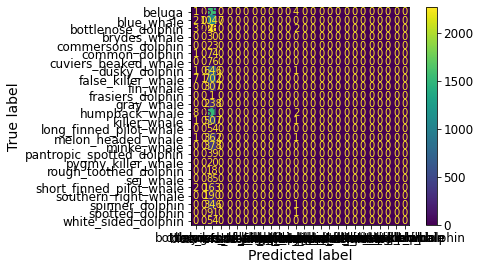

In [60]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(labels_val, pred_val)
cm = confusion_matrix(np.arange(26), np.arange(26))
cmp = ConfusionMatrixDisplay(cm, display_labels=np.arange(26))
fig, ax = plt.subplots(figsize=(10,10))

In [ ]:
cmp.plot(ax=ax)

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(labels_val, pred_val)

In [57]:
disp = disp.plt()

In [61]:
# saving the confusion matrix
store_conf_matrix(fig, "RandomForest")

AttributeError: 'ConfusionMatrixDisplay' object has no attribute 'savefig'

## Hyperparamter Tuning RandomForest Classifier

In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [39]:
# Selecting Parameters of Random Forest Classifier for Grid Search

params_grid_RF = [
    {"n_estimators": [100, 500, 1000, 2000],
     "criterion":["gini","entropy"],
     "max_features": ["auto", "log2", "sqrt"],
     "bootstrap": [True, False],
     "max_depth": [90, 100, 110],
     "min_samples_leaf": [1, 2, 4],
     "min_samples_split": [2, 5, 10]}
]


In [40]:
classifier_RF_hyper = RandomForestClassifier()

In [ ]:
# Perform Randomized Search

scoring = ["f1_macro", "accuracy", "precision_macro", "recall_macro"]


randomized_search = RandomizedSearchCV(estimator = classifier_RF_hyper,
                           param_distributions = params_grid_RF,
                           n_iter=10,
                           cv = 3,
                           scoring= scoring,
                           refit = "precision_macro",
                           n_jobs = -1,
                           verbose = 3,
                           return_train_score = True)

randomized_search.fit(img_data_train, labels_train)



In [ ]:
# Perform Grid-Search
#Takes too loooong

scoring = ["f1_macro", "precision_macro", "recall_macro"]


grid_search = GridSearchCV(estimator = classifier_RF_hyper,
                           param_grid = params_grid_RF,
                           cv = 3,
                           scoring= scoring,
                           refit = "precision_macro",
                           n_jobs = -1,
                           verbose = 3,
                           return_train_score = True)
    
grid_search.fit(img_data_train, labels_train)

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


In [ ]:
print(randomized_search.best_params_)
best_hyppar_dict = {}
best_hyppar_dict["Randomized_Search_Best_Params"] = randomized_search.best_params_

In [ ]:
def store_best_hyperpar(image_df, classifier_name):
    savez_compressed(OUTPUT_PATH_HYPPAR_TUN + "/best_hyperpar_"+str(classifier_name)+".npz",image_df)
    print("file successfully stored in: output/ml_models/04_hyperparamter_tuning")

In [ ]:
best_params_dict = best_hyppar_dict
store_best_hyperpar(best_params_dict, "RandomForestTuned")

## Evaluate tuned RF classifier

In [ ]:
## define the tuned classifier with the best hyperparamters
## these here are still random ones

num_trees = 10 # change to actual value

classifier_RF_tuned = RandomForestClassifier(class_weight='balanced',
                                      criterion='gini',
                                      max_depth=55,
                                      max_features='log2',
                                      min_samples_leaf=0.005,
                                      min_samples_split=0.005,
                                      n_estimators=num_trees)

classifier_RF_tuned.fit(img_data_train,labels_train)

In [ ]:
# store predictions of classifier
pred_train = classifier_RF_tuned.predict(img_data_train)
pred_val = classifier_RF_tuned.predict(img_data_val)

# evaluate classifier and store metrics 
evaluation_scores = {"Precision Score Train": precision_score(labels_train, pred_train, average = "macro").round(3),
                     "Precision Score Validation": precision_score(labels_val, pred_val, average = "macro").round(3),
                     "Recall Score Train": recall_score(labels_train, pred_train, average = "macro").round(3),
                     "Recall Score Validation": recall_score(labels_val, pred_val, average = "macro").round(3),
                     "F1 Score Train": f1_score(labels_train, pred_train, average="macro").round(3),
                     "F1 Score Validation": f1_score(labels_val, pred_val, average="macro").round(3)}


In [ ]:
store_eval_score(evaluation_scores, "RandomForest_tuned")

In [ ]:
## Multiclass Confusion Matrix

### Checking Feature importance of RF

In [ ]:
# This needs to be done on the full image data (pre-PCA)
## define the tuned classifier with the best hyperparamters
## these here are still random ones

num_trees = 10 # change to actual value

classifier_RF_tuned_no_PCA = RandomForestClassifier(class_weight='balanced',
                                      criterion='gini',
                                      max_depth=55,
                                      max_features='log2',
                                      min_samples_leaf=0.005,
                                      min_samples_split=0.005,
                                      n_estimators=num_trees)

classifier_RF_tuned.fit(img_data_train_no_PCA,labels_train_no_PCA)

In [ ]:
# Defining the function to plot the digits of feature importance
# Adapted from Aurelien Geron:

pix_res = 48

def plot_digit(data):
    image = data.reshape(pix_res, pix_res)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# Adding feature importances from 3 RGB values to one pixel
feature_imp_sum = np.empty([(int(len(classifier_RF_tuned_no_PCA.feature_importances_)/3)),])

for itr in range(int(len(classifier_RF_tuned_no_PCA.feature_importances_)/3)):
    r = int(itr*3)
    g = int(r+1)
    b = int(g+1)
    feature_imp_sum[itr] = classifier_RF_tuned_no_PCA.feature_importances_[r] + classifier_RF_tuned_no_PCA.feature_importances_[g] + classifier_RF_tuned_no_PCA.feature_importances_[b]


In [ ]:
# Plotting feature importance sum for every pixel to a plot and save it
plot_digit(feature_imp_sum)

cbar = plt.colorbar(ticks=[feature_imp_sum.min(), feature_imp_sum.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

In [ ]:
save_fig("RandomForest_feature_importance_plot_full_data")



## Implementing XGBoost as second advanced model

In [ ]:
import xgboost as xgb

classifier_XGB = xgb.XGBClassifier(objective="binary:logistic", random_state=42, eval_metric="auc")
classifier_XGB.fit(img_data_train, labels_train, early_stopping_rounds=5, eval_set=[(img_data_val, labels_val)])


## Evaluating XGBoost Classifier

In [ ]:
# store predictions of classifier
pred_train = classifier_XGB.predict(img_data_train)
pred_val = classifier_XGB.predict(img_data_val)

In [ ]:
# evaluate classifier and store metrics
evaluation_scores = {"Precision Score Train": precision_score(labels_train, pred_train, average = "macro").round(3),
                     "Precision Score Validation": precision_score(labels_val, pred_val, average = "macro").round(3),
                     "Recall Score Train": recall_score(labels_train, pred_train, average = "macro").round(3),
                     "Recall Score Validation": recall_score(labels_val, pred_val, average = "macro").round(3),
                     "F1 Score Train": f1_score(labels_train, pred_train, average="macro").round(3),
                     "F1 Score Validation": f1_score(labels_val, pred_val, average="macro").round(3)}

In [ ]:
store_eval_score(evaluation_scores, "XGBoost")

In [ ]:
# Inspecting the errors
output_dict = {}
output_array = np.c_[pic_ids_val, labels_val, pred_val] ## adjust name of pic_ids and labels depending on train or val

# Create error array with specific error
err_type_arr = np.array([])
for i in range(len(output_array)):
    if output_array[i,1] != output_array[i,2]:
        err_type_arr = np.append(err_type_arr, "error")
    else:
        err_type_arr = np.append(err_type_arr, "No error")

error_table_pd = pd.DataFrame(output_array)
error_table_pd.rename(columns = {0:'Picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
error_table_pd["Error Check"] = err_type_arr

# print filtered error table
print(error_table_pd.loc[error_table_pd["Error Check"].isin(["error"])].sort_values(by=["Label", "Picture ID"]))

In [ ]:
# transform pd frame into dictionary for saving
output_dict["error_table"] = error_table_pd

# saving the error table
store_error_table(output_dict, "XGBoost")


## Hyperparamter Tuning XGBoost Classifier

In [ ]:
from scipy.stats import uniform

In [ ]:
# Selecting Parameters of XGBoost Classifier for Grid Search

params_grid_XGB = [{
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1
    "max_depth": [15, 20 25],
    "n_estimators": [400, 700, 1000],
    "subsample": uniform(0.6, 0.4)}
]


In [ ]:
classifier_XGB_hyper = xgb.XGBClassifier()

In [ ]:
# Perform Grid-Search

scoring = ["f1_macro", "precision_macro", "recall_macro"]

grid_search = GridSearchCV(estimator = classifier_XGB_hyper,
                           param_grid = params_grid_XGB,
                           cv = 3,
                           scoring= scoring,
                           refit = "precision",
                           n_jobs = -1,
                           verbose = 3,
                           return_train_score = True)

grid_search.fit(img_data_train, labels_train)

In [ ]:
print(grid_search.best_params_)
best_hyppar_dict = {}
best_hyppar_dict["Grid_Search_Best_Params"] = grid_search.best_params_


In [ ]:
best_params_dict = best_hyppar_dict
store_best_hyperpar(best_params_dict, "XGBoostTuned")

## Evaluate tuned XGBoost classifier

In [ ]:
## define the tuned classifier with the best hyperparamters
## these here are still random ones

classifier_XGB_tuned = xgb.XGBClassifier(colsample_bytree=0.7, gamma=0.5, learning_rate=0.3,max_depth=25, subsample=0.5,n_estimators=700)

classifier_XGB_tuned.fit(img_data_train,labels_train)

In [ ]:
# store predictions of classifier
pred_train = classifier_XGB_tuned.predict(img_data_train)
pred_val = classifier_XGB_tuned.predict(img_data_val)

# evaluate classifier and store metrics
evaluation_scores = {"Precision Score Train": precision_score(labels_train, pred_train, average = "macro").round(3),
                     "Precision Score Validation": precision_score(labels_val, pred_val, average = "macro").round(3),
                     "Recall Score Train": recall_score(labels_train, pred_train, average = "macro").round(3),
                     "Recall Score Validation": recall_score(labels_val, pred_val, average = "macro").round(3),
                     "F1 Score Train": f1_score(labels_train, pred_train, average="macro").round(3),
                     "F1 Score Validation": f1_score(labels_val, pred_val, average="macro").round(3)}


In [ ]:
store_eval_score(evaluation_scores, "XGBoost_tuned")

In [ ]:
## Multiclass Confusion Matrix




## Speed improvements through dimensionality reduction

### Checking Feature importance of RF

In [ ]:
# Defining the function to plot the digits of feature importance
# Adapted from Aurelien Geron:

pix_res = 48

def plot_digit(data):
    image = data.reshape(pix_res, pix_res)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
# Adding feature importances from 3 RGB values to one pixel
feature_imp_sum = np.empty([(int(len(classifier_RF_tuned.feature_importances_)/3)),])

for itr in range(int(len(classifier_RF_tuned.feature_importances_)/3)):
    r = int(itr*3)
    g = int(r+1)
    b = int(g+1)
    feature_imp_sum[itr] = classifier_RF_tuned.feature_importances_[r] + classifier_RF_tuned.feature_importances_[g] + classifier_RF_tuned.feature_importances_[b]


In [ ]:
# Plotting feature importance sum for every pixel to a plot and save it
plot_digit(feature_imp_sum)

cbar = plt.colorbar(ticks=[feature_imp_sum.min(), feature_imp_sum.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

In [ ]:
save_fig("RandomForest_feature_importance_plot_full_data")

### Performing Principal Component Analysis on the training data

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
img_data_full.shape

In [ ]:
# defining to keep 99% of the variance of the data 
pca = PCA(.99)
img_data_full_red = pca.fit_transform(img_data_full)

In [ ]:
# checking how many features are left 
img_data_full_red.shape

In [ ]:
# Split into training and test set - 10.000 test set / 40.000 full training set
# stratify = labels splits it proportionally to classes in the dataset

from sklearn.model_selection import train_test_split
img_data_train_full, img_data_test, labels_train_full, labels_test, pic_ids_train_full, pic_ids_test = train_test_split(img_data_full_red , labels_full, pic_ids_full, stratify=labels_full, test_size=0.2, random_state=42)

In [ ]:
# Split into training and validation set - 30.000 training set / 10.000 validation set
from sklearn.model_selection import train_test_split
img_data_train, img_data_val, labels_train, labels_val, pic_ids_train, pic_ids_val = train_test_split(img_data_train_full , labels_train_full, pic_ids_train_full, train_size=30000, random_state=42)

### Evaluate speed tuned RF classifier

In [ ]:
# Victor: muss man dann hier nochmal das ganze training (direkt mit den gefundenen hyperparametern) und 
# evaluation nochmal machen? Schon oder?
# und dann besteht die Gefahr, dass die Hyperparameter nicht mehr ideal sind und man die dann nochmal
# fine tunen muss (so wars bei Thilo) aber falls die predictions nicht zu schlecht sind können wir auch argumentieren
# dass wir das aufgrund von run-time and scope limitations of our project nicht mehr machen

In [ ]:
## define the tuned classifier with the best hyperparamters
## these here are still random ones

num_trees = 10 # change to actual value

classifier_RF_tuned_PCA = RandomForestClassifier(class_weight='balanced',
                                      criterion='gini',
                                      max_depth=55,
                                      max_features='log2',
                                      min_samples_leaf=0.005,
                                      min_samples_split=0.005,
                                      n_estimators=num_trees)

classifier_RF_tuned_PCA.fit(img_data_train,labels_train)

In [ ]:
# store predictions of classifier
pred_train = classifier_RF_tuned_PCA.predict(img_data_train)
pred_val = classifier_RF_tuned_PCA.predict(img_data_val)

# evaluate classifier and store metrics
evaluation_scores = {"Precision Score Train": precision_score(labels_train, pred_train, average = "macro").round(3),
                     "Precision Score Validation": precision_score(labels_val, pred_val, average = "macro").round(3),
                     "Recall Score Train": recall_score(labels_train, pred_train, average = "macro").round(3),
                     "Recall Score Validation": recall_score(labels_val, pred_val, average = "macro").round(3),
                     "F1 Score Train": f1_score(labels_train, pred_train, average="macro").round(3),
                     "F1 Score Validation": f1_score(labels_val, pred_val, average="macro").round(3)}


In [ ]:
store_eval_score(evaluation_scores, "RandomForest_tuned_PCA")

### Evaluate speed tuned XGB classifier

In [ ]:
## define the tuned classifier with the best hyperparamters
## these here are still random ones

classifier_XGB_tuned_PCA = xgb.XGBClassifier(colsample_bytree=0.7, gamma=0.5, learning_rate=0.3,max_depth=25, subsample=0.5,n_estimators=700)

classifier_XGB_tuned_PCA.fit(img_data_train,labels_train)

In [ ]:
# store predictions of classifier
pred_train = classifier_XGB_tuned_PCA.predict(img_data_train)
pred_val = classifier_XGB_tuned_PCA.predict(img_data_val)

# evaluate classifier and store metrics
evaluation_scores = {"Precision Score Train": precision_score(labels_train, pred_train, average = "macro").round(3),
                     "Precision Score Validation": precision_score(labels_val, pred_val, average = "macro").round(3),
                     "Recall Score Train": recall_score(labels_train, pred_train, average = "macro").round(3),
                     "Recall Score Validation": recall_score(labels_val, pred_val, average = "macro").round(3),
                     "F1 Score Train": f1_score(labels_train, pred_train, average="macro").round(3),
                     "F1 Score Validation": f1_score(labels_val, pred_val, average="macro").round(3)}


In [ ]:
store_eval_score(evaluation_scores, "XGBoost_tuned_PCA")


## Final Evaluation on Test Set

In [ ]:
## test baseline and untuned RF on test set

In [ ]:
## test tuned RF on test set